<a href="https://colab.research.google.com/github/alby1976/Data607608Project/blob/master/notebook/DATA607_Question1_GaussianNaiveBayes_and_RandomForest_YuNakamura.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Machine Learning Question 1
**Is there any pattern of solved or unsolved cases based on the type of victim, weapon, circumstance and geography region where crimes were occurred?**

To address this question, we implemented below three models to predict Solved or Unsolved cases with Case level records reported by Murder Accountability Project.
 
- Classification models with `scikit-lean`: 
  `Gausian Naive Bayes Classifer` and `Regression forest classifer`
- Deep learning Model with `Tensorflows` and `keras`:
  `Neural Network`

Murder Accountability Projects compiled various information such as geographic location, Victim profile, Offender profile, year/month, type of weapon, relationship between victim and offender, homicide type, circumstance etc for 80,4751 caeses from 1976 to 2019.

For our prediction model, we used "solved" column (yes, or no) as a response variable and feed others as explanatory variables.


In [ ]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.spatial.distance as spd
import scipy.cluster.hierarchy as sph
import sklearn as sk
import sklearn.cluster as skc
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns
sns.set(style='white', color_codes=True, font_scale=1.3)

In [ ]:
from google.colab import files
data_to_load = files.upload()

import io
MAP = pd.read_csv(io.BytesIO(data_to_load["SHR76_19.csv"]))

Saving SHR76_19.csv to SHR76_19.csv


In [ ]:
MAP

,ID,CNTYFIPS,Ori,State,Agency,Agentype,Source,Solved,Year,StateName,Month,Incident,ActionType,Homicide,Situation,VicAge,VicSex,VicRace,VicEthnic,OffAge,OffSex,OffRace,OffEthnic,Weapon,Relationship,Circumstance,Subcircum,VicCount,OffCount,FileDate,MSA,code
0,197603001AK00101,"Anchorage, AK",AK00101,Alaska,Anchorage,Municipal police,FBI,Yes,1976,NaN,March,1,Normal update,Murder and non-negligent manslaughter,Single victim/single offender,48,Male,Unknown,Unknown or not reported,68,Male,Black,Unknown or not reported,"Handgun - pistol, revolver, etc",Relationship not determined,Other arguments,NaN,0,0,30180.0,"Anchorage, AK",AK
1,197604001AK00101,"Anchorage, AK",AK00101,Alaska,Anchorage,Municipal police,FBI,Yes,1976,NaN,April,1,Normal update,Murder and non-negligent manslaughter,Single victim/single offender,33,Female,White,Unknown or not reported,44,Male,White,Unknown or not reported,"Handgun - pistol, revolver, etc",Girlfriend,Other arguments,NaN,0,0,30180.0,"Anchorage, AK",AK
2,197606001AK00101,"Anchorage, AK",AK00101,Alaska,Anchorage,Municipal police,FBI,Yes,1976,NaN,June,1,Normal update,Murder and non-negligent manslaughter,Single victim/single offender,38,Male,White,Unknown or not reported,27,Male,Black,Unknown or not reported,"Handgun - pistol, revolver, etc",Stranger,Other,NaN,0,0,30180.0,"Anchorage, AK",AK
3,197606002AK00101,"Anchorage, AK",AK00101,Alaska,Anchorage,Municipal police,FBI,Yes,1976,NaN,June,2,Normal update,Murder and non-negligent manslaughter,Single victim/single offender,41,Male,White,Unknown or not reported,34,Male,White,Unknown or not reported,"Handgun - pistol, revolver, etc",Other - known to victim,Other arguments,NaN,0,0,30180.0,"Anchorage, AK",AK
4,197607001AK00101,"Anchorage, AK",AK00101,Alaska,Anchorage,Municipal police,FBI,Yes,1976,NaN,July,1,Normal update,Murder and non-negligent manslaughter,Single victim/single offender,33,Male,American Indian or Alaskan Native,Unknown or not reported,37,Female,American Indian or Alaskan Native,Unknown or not reported,Knife or cutting instrument,Brother,Other arguments,NaN,0,0,30180.0,"Anchorage, AK",AK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804746,201511001WYDI050,"Fremont, WY",WYDI050,Wyoming,Wind River Agency,Tribal,FBI,Yes,2015,NaN,November,1,Normal update,Murder and non-negligent manslaughter,Single victim/single offender,37,Female,Unknown,Unknown or not reported,51,Male,American Indian or Alaskan Native,Not of Hispanic origin,"Handgun - pistol, revolver, etc",Common-law husband,Other - not specified,NaN,0,0,32316.0,Rural Wyoming,WY
804747,201707001WYDI050,"Fremont, WY",WYDI050,Wyoming,Wind River Agency,Tribal,FBI,Yes,2017,NaN,July,1,Normal update,Murder and non-negligent manslaughter,Single victim/single offender,43,Male,American Indian or Alaskan Native,Not of Hispanic origin,38,Male,American Indian or Alaskan Native,Not of Hispanic origin,Knife or cutting instrument,Friend,Brawl due to influence of alcohol,NaN,0,0,102418.0,Rural Wyoming,WY
804748,201711001WYDI050,"Fremont, WY",WYDI050,Wyoming,Wind River Agency,Tribal,FBI,Yes,2017,NaN,November,1,Normal update,Murder and non-negligent manslaughter,Single victim/single offender,36,Male,American Indian or Alaskan Native,Not of Hispanic origin,39,Male,American Indian or Alaskan Native,Not of Hispanic origin,"Blunt object - hammer, club, etc",Acquaintance,Brawl due to influence of alcohol,NaN,0,0,102418.0,Rural Wyoming,WY
804749,201808001WYDI050,"Fremont, WY",WYDI050,Wyoming,Wind River Agency,Tribal,FBI,No,2018,NaN,August,1,Normal update,Murder and non-negligent manslaughter,Single victim/unknown offender(s),29,Male,American Indian or Alaskan Native,Not of Hispanic origin,999,Unknown,Unknown,Unknown or not reported,Shotgun,Other - known to victim,Narcotic drug laws,NaN,0,0,93019.0,Rural Wyoming,WY


First, we selected explanatory variables to give to the model. Through Explanatory Data Analysis, we found that the cases which clear offender's desctipritons (age, sex, race, ehnic) are provided, are most-likely labeled as a "solved" case. This does make sense since if there is enough evidence and information about offenders, police most-likely can arrest them.

In order to provide more useful insights through our guiding question, we excluded the data related to offender type, and focused on only type of victim, type of killing methodology as well as geolgraphic locations to figure out what features are keys for the purpose of success of case solving.

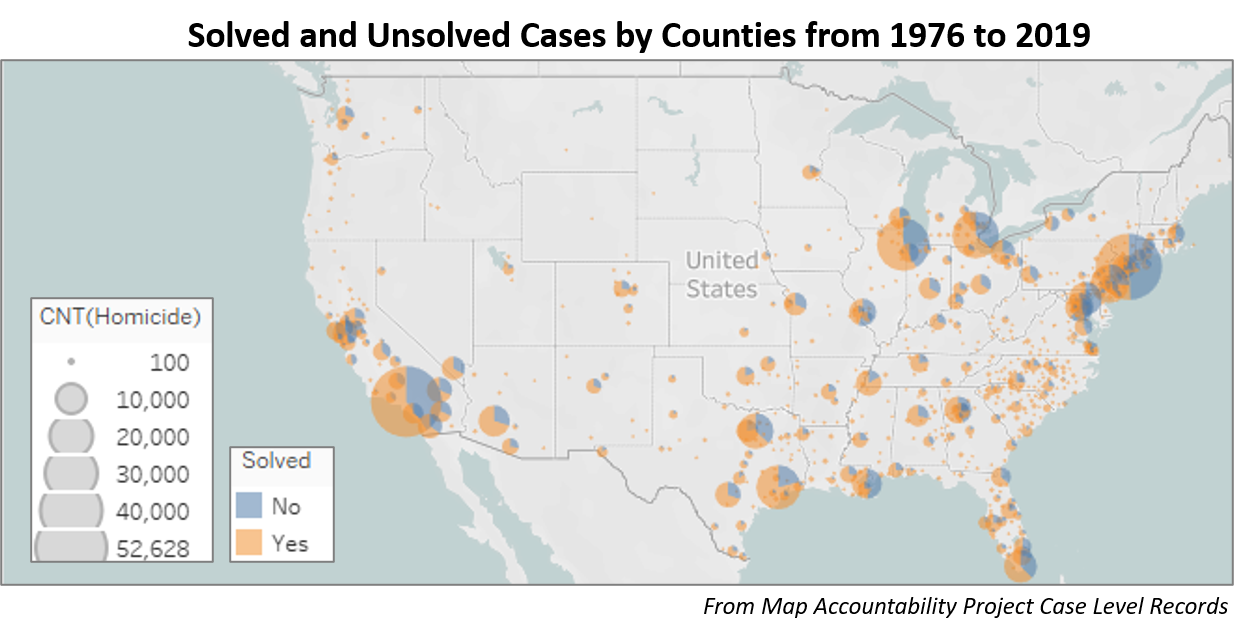
*Fig. Solved and Unsolved cases by County, United State reported from Murder Accountability Project*


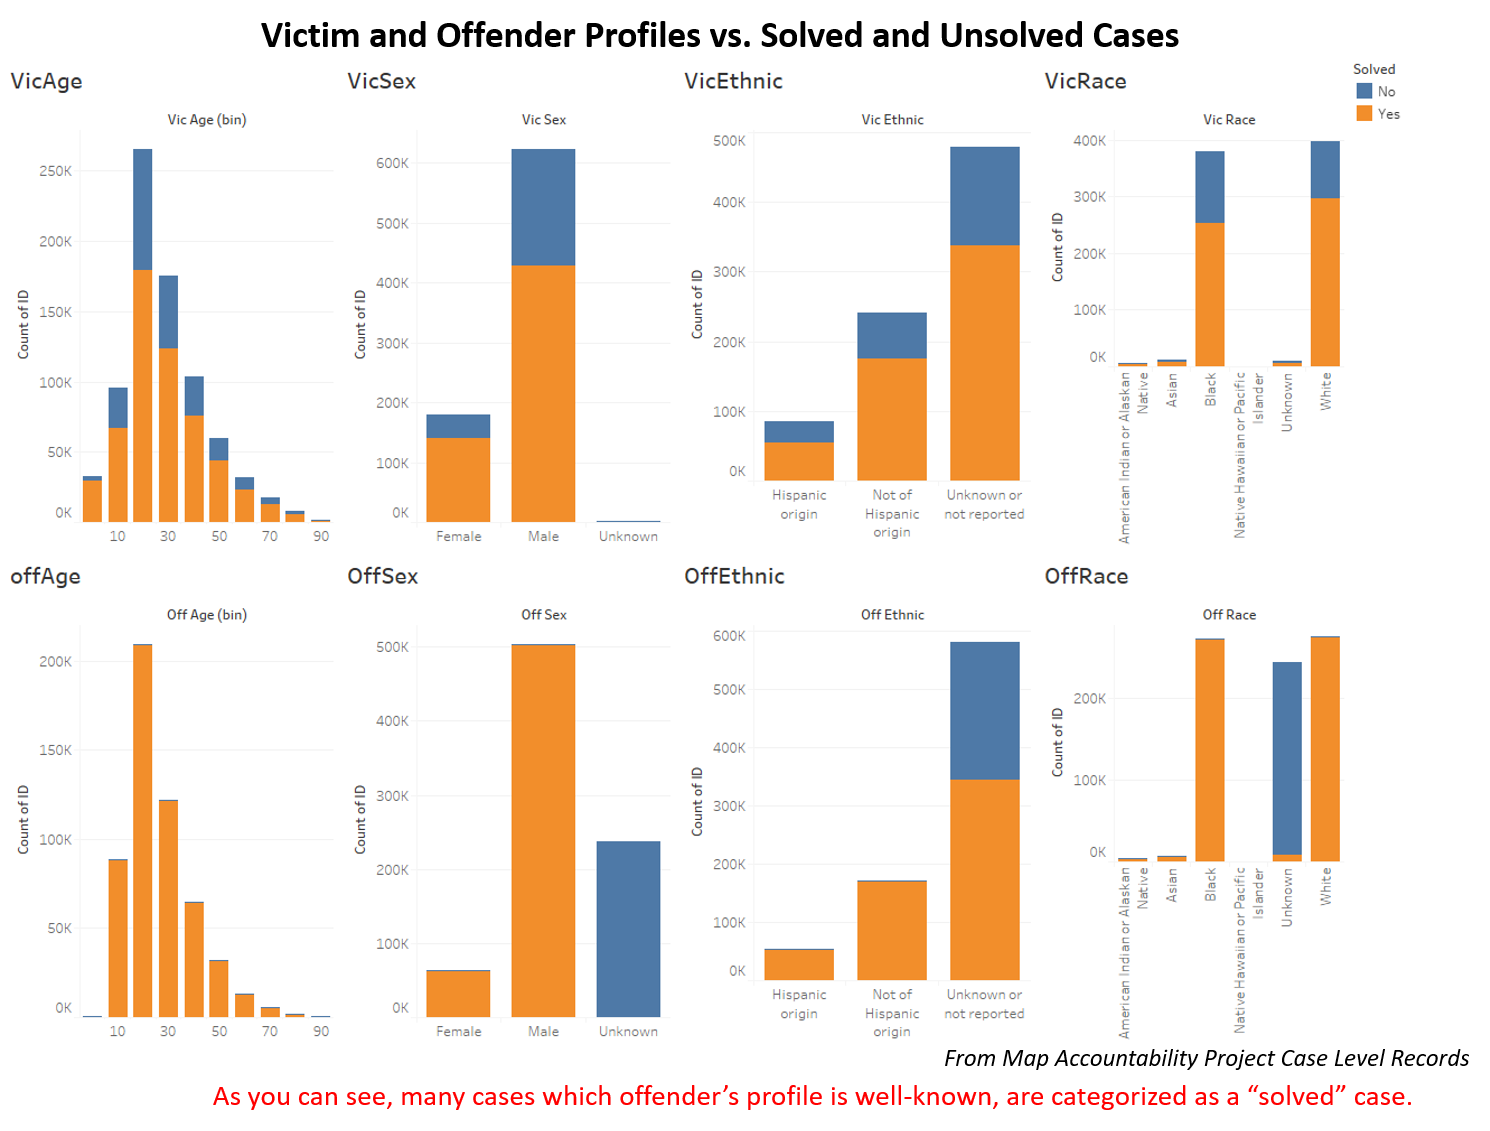
*Fig. Solved and Unsolved cases vs. Victim and Offender's profile*

In [ ]:
df = MAP[['CNTYFIPS', 'State', 'Solved','Year', 'Incident', 'Homicide', 'Situation', 'VicAge', 'VicSex', 'VicRace', 'VicEthnic',
       'Weapon', 'Relationship',
       'Circumstance', 'Subcircum', 'VicCount', 'OffCount']]
#df = df[(df["Year"] >= 2000) & (df["Year"] <= 2019)].reset_index()
df = df.dropna()

In [ ]:
print(df.keys(), '\n', df.shape)
df.head()

Index(['CNTYFIPS', 'State', 'Solved', 'Year', 'Incident', 'Homicide',
       'Situation', 'VicAge', 'VicSex', 'VicRace', 'VicEthnic', 'Weapon',
       'Relationship', 'Circumstance', 'Subcircum', 'VicCount', 'OffCount'],
      dtype='object') 
 (31502, 17)


,CNTYFIPS,State,Solved,Year,Incident,Homicide,Situation,VicAge,VicSex,VicRace,VicEthnic,Weapon,Relationship,Circumstance,Subcircum,VicCount,OffCount
46,"Anchorage, AK",Alaska,Yes,1979,3,Murder and non-negligent manslaughter,Single victim/single offender,19,Male,White,Unknown or not reported,"Handgun - pistol, revolver, etc",Stranger,Felon killed by private citizen,Felon killed in commission of a crime,0,0
212,"Anchorage, AK",Alaska,No,1989,1,Murder and non-negligent manslaughter,Single victim/unknown offender(s),31,Male,Black,Unknown or not reported,Shotgun,Stranger,Felon killed by police,Felon attacked fellow police officer,0,0
275,"Anchorage, AK",Alaska,No,1993,3,Murder and non-negligent manslaughter,Single victim/unknown offender(s),22,Male,American Indian or Alaskan Native,Unknown or not reported,"Handgun - pistol, revolver, etc",Relationship not determined,Felon killed by police,Felon attacked police officer,0,0
279,"Anchorage, AK",Alaska,No,1993,3,Murder and non-negligent manslaughter,Single victim/unknown offender(s),20,Male,Black,Unknown or not reported,Rifle,Relationship not determined,Felon killed by police,Felon killed in commission of a crime,0,0
298,"Anchorage, AK",Alaska,Yes,1994,1,Murder and non-negligent manslaughter,Single victim/single offender,29,Male,Black,Unknown or not reported,"Handgun - pistol, revolver, etc",Stranger,Felon killed by private citizen,Felon attacked fellow police officer,0,0


### Gaussian Naive Bayes Model
In this section, we explain how to implement Gaussian Naive Bayes Model with MAP dataset.
- Our dataset includes a lot of dummy variables. Before running machine learning model, it is necessary to encode categorical columns for all dummy variables. Here is the code of encoding with `preprocessing` packages from `sklearn`.

In [ ]:
# For preprocessing the data
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
Homicide_cat = le.fit_transform(df.Homicide)
State_cat = le.fit_transform(df.State)
VicSex_cat = le.fit_transform(df.VicSex) 
VicRace_cat = le.fit_transform(df.VicRace)
VicEthnic_cat = le.fit_transform(df.VicEthnic)
Weapon_cat = le.fit_transform(df.Weapon)
Relationship_cat = le.fit_transform(df.Relationship)
Circumstance_cat = le.fit_transform(df.Circumstance)
Subcircum_cat = le.fit_transform(df.Subcircum)

# initialize the encoded categorical columns
df['Homicide_cat'] = Homicide_cat
df['State_cat'] = State_cat
df['VicSex_cat'] = VicSex_cat 
df['VicRace_cat'] = VicRace_cat
df['VicEthnic_cat'] = VicEthnic_cat
df['Weapon_cat'] = Weapon_cat
df['Relationship_cat'] = Relationship_cat
df['Circumstance_cat'] = Circumstance_cat
df['Subcircum_cat'] = Subcircum_cat

In [ ]:
df.keys()

Index(['CNTYFIPS', 'State', 'Solved', 'Year', 'Incident', 'Homicide',
       'Situation', 'VicAge', 'VicSex', 'VicRace', 'VicEthnic', 'Weapon',
       'Relationship', 'Circumstance', 'Subcircum', 'VicCount', 'OffCount',
       'Homicide_cat', 'State_cat', 'VicSex_cat', 'VicRace_cat',
       'VicEthnic_cat', 'Weapon_cat', 'Relationship_cat', 'Circumstance_cat',
       'Subcircum_cat'],
      dtype='object')

In [ ]:
dummy_fields = ['CNTYFIPS', 'State', 'Solved', 'Year', 'Homicide',
       'Situation', 'VicSex', 'VicRace', 'VicEthnic', 'Weapon',
       'Relationship', 'Circumstance', 'Subcircum']
new_df_forGNB = df.drop(dummy_fields, axis = 1)
new_df_forGNB

,Incident,VicAge,VicCount,OffCount,Homicide_cat,State_cat,VicSex_cat,VicRace_cat,VicEthnic_cat,Weapon_cat,Relationship_cat,Circumstance_cat,Subcircum_cat
46,3,19,0,0,1,1,1,5,2,5,25,2,4
212,1,31,0,0,1,1,1,2,2,11,25,1,1
275,3,22,0,0,1,1,1,0,2,5,19,1,2
279,3,20,0,0,1,1,1,2,2,10,19,1,4
298,1,29,0,0,1,1,1,2,2,5,25,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
804552,1,35,0,4,1,50,1,5,2,11,25,1,5
804553,1,45,0,0,1,50,1,5,2,5,17,1,2
804568,1,25,0,0,1,50,1,5,1,11,25,1,1
804717,1,49,0,0,1,50,1,5,2,11,25,1,2


- Now, set up y and X variables.

In [ ]:
# Set X and y variables for our prediction Model
X = new_df_forGNB.values.astype(float)
y = (df.Solved.values == "Yes").astype(int) # 1: Solved = yes, 0: No 
print(X.shape, y.shape)

(31502, 13) (31502,)


- We ran **Gausian Naive Byes** Model as below:

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

# Split data into training and test datasets
np.random.seed(22)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = 0.2)

# fit a model
gnb = GaussianNB()
gnb.fit(X_tr, y_tr)

# calculate training error
y_pr_tr = gnb.predict(X_tr)
tr_err = np.mean(y_pr_tr != y_tr)

# calculate testing error
y_pr = gnb.predict(X_te)
test_err = np.mean(y_pr != y_te)
print(f"testing error = {test_err:.6f}", f"training error = {tr_err:.6f}")

testing error = 0.317093 training error = 0.321297


- From a result above, the testing error of Gausiann Naive model is 0.317. 

### Random Forest
As explained above, our first model `Gaussian Naive Bayes` has 0.317 of a testing error. Can we decrease test error with Random Forest Classifer method?

First, data processing is required.
- Our dataset includes a lot of dummy variables. To build random forest model, here is the code to create boolean type logs for each categories.

In [ ]:
# Two categories
cols = {}
cols["Homicide"] = df.Homicide == "Murder and non-negligent manslaughter"

# Add other columns you want to use for ML
cols['Incident'] = df.Incident
cols['VicAge'] = df.VicAge
cols['VicCount'] = df.VicCount
cols['OffCount'] = df.OffCount

In [ ]:
# Multiple dummy columns
CATS = ["State", "VicSex", "VicRace", "VicEthnic",  'Weapon', 'Relationship', 'Circumstance', 'Subcircum']
CATS

['State',
 'VicSex',
 'VicRace',
 'VicEthnic',
 'Weapon',
 'Relationship',
 'Circumstance',
 'Subcircum']

In [ ]:
for c in CATS:
    print(c, set(df[c]))

State {'Georgia', 'Wisconsin', 'North Dakota', 'Montana', 'District of Columbia', 'Vermont', 'West Virginia', 'South Carolina', 'Kentucky', 'Louisiana', 'Kansas', 'Idaho', 'Connecticut', 'Michigan', 'New Mexico', 'Nevada', 'Tennessee', 'Oregon', 'Washington', 'Mississippi', 'Wyoming', 'New Hampshire', 'North Carolina', 'Arkansas', 'Rhodes Island', 'Alabama', 'Colorado', 'Arizona', 'Oklahoma', 'Maine', 'Alaska', 'Massachusetts', 'California', 'New Jersey', 'Hawaii', 'Iowa', 'New York', 'Maryland', 'South Dakota', 'Utah', 'Texas', 'Indiana', 'Nebraska', 'Delaware', 'Ohio', 'Minnesota', 'Pennsylvania', 'Virginia', 'Illinois', 'Florida', 'Missouri'}
VicSex {'Female', 'Unknown', 'Male'}
VicRace {'Native Hawaiian or Pacific Islander', 'Unknown', 'White', 'Black', 'American Indian or Alaskan Native', 'Asian'}
VicEthnic {'Not of Hispanic origin', 'Unknown or not reported', 'Hispanic origin'}
Weapon {'Personal weapons, includes beating', 'Strangulation - hanging', 'Rifle', 'Fire', 'Firearm, typ

In [ ]:
for c in CATS:
  for value in set(df[c]):
    cols[c + "__" + "_".join(value.split(" "))] = df[c] == value

In [ ]:
new_df = pd.DataFrame(cols)
new_df.head()

,Homicide,Incident,VicAge,VicCount,OffCount,State__Georgia,State__Wisconsin,State__North_Dakota,State__Montana,State__District_of_Columbia,State__Vermont,State__West_Virginia,State__South_Carolina,State__Kentucky,State__Louisiana,State__Kansas,State__Idaho,State__Connecticut,State__Michigan,State__New_Mexico,State__Nevada,State__Tennessee,State__Oregon,State__Washington,State__Mississippi,State__Wyoming,State__New_Hampshire,State__North_Carolina,State__Arkansas,State__Rhodes_Island,State__Alabama,State__Colorado,State__Arizona,State__Oklahoma,State__Maine,State__Alaska,State__Massachusetts,State__California,State__New_Jersey,State__Hawaii,...,"Weapon__Blunt_object_-_hammer,_club,_etc",Weapon__Other_gun,Weapon__Knife_or_cutting_instrument,Relationship__Boyfriend,Relationship__Acquaintance,Relationship__Wife,Relationship__Mother,Relationship__Common-law_husband,Relationship__Other_family,Relationship__Homosexual_relationship,Relationship__Ex-wife,Relationship__Neighbor,Relationship__Sister,Relationship__Stepfather,Relationship__Friend,Relationship__Stepson,Relationship__Ex-husband,Relationship__Brother,Relationship__Common-law_wife,Relationship__Stranger,Relationship__Stepdaughter,Relationship__Father,Relationship__Girlfriend,Relationship__Relationship_not_determined,Relationship__Husband,Relationship__In-law,Relationship__Daughter,Relationship__Other_-_known_to_victim,Relationship__Employee,Relationship__Son,Circumstance__Felon_killed_by_police,Circumstance__Felon_killed_by_private_citizen,Circumstance__Circumstances_undetermined,Subcircum__Felon_attempted_flight_from_a_crime,Subcircum__Felon_attacked_police_officer,Subcircum__Felon_resisted_arrest,Subcircum__Felon_attacked_fellow_police_officer,Subcircum__Felon_attacked_a_civilian,Subcircum__Felon_killed_in_commission_of_a_crime,Subcircum__Not_enough_information_to_determine
46,True,3,19,0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False
212,True,1,31,0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False
275,True,3,22,0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False
279,True,3,20,0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False
298,True,1,29,0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False

In [ ]:
new_df.keys()

Index(['Homicide', 'Incident', 'VicAge', 'VicCount', 'OffCount',
       'State__Georgia', 'State__Wisconsin', 'State__North_Dakota',
       'State__Montana', 'State__District_of_Columbia',
       ...
       'Circumstance__Felon_killed_by_police',
       'Circumstance__Felon_killed_by_private_citizen',
       'Circumstance__Circumstances_undetermined',
       'Subcircum__Felon_attempted_flight_from_a_crime',
       'Subcircum__Felon_attacked_police_officer',
       'Subcircum__Felon_resisted_arrest',
       'Subcircum__Felon_attacked_fellow_police_officer',
       'Subcircum__Felon_attacked_a_civilian',
       'Subcircum__Felon_killed_in_commission_of_a_crime',
       'Subcircum__Not_enough_information_to_determine'],
      dtype='object', length=118)

- Since "unknown" columns such as 'VicSex__Unknown', 'Weapon__Other_or_type_unknown' etc. have an bias which tends to categorize as a "unsolved" case due to a lack of information captured. 
- To avoid to have this data bias for the prediction, drop "unknwon" columns.


In [ ]:
new_df.drop(columns=['VicSex__Unknown', 'VicRace__Unknown', 'VicEthnic__Unknown_or_not_reported', 'Weapon__Other_or_type_unknown', 'Relationship__Relationship_not_determined','Circumstance__Circumstances_undetermined', 'Subcircum__Not_enough_information_to_determine'], inplace=True)

In [ ]:
new_df.keys()

Index(['Homicide', 'Incident', 'VicAge', 'VicCount', 'OffCount',
       'State__Georgia', 'State__Wisconsin', 'State__North_Dakota',
       'State__Montana', 'State__District_of_Columbia',
       ...
       'Relationship__Employee', 'Relationship__Son',
       'Circumstance__Felon_killed_by_police',
       'Circumstance__Felon_killed_by_private_citizen',
       'Subcircum__Felon_attempted_flight_from_a_crime',
       'Subcircum__Felon_attacked_police_officer',
       'Subcircum__Felon_resisted_arrest',
       'Subcircum__Felon_attacked_fellow_police_officer',
       'Subcircum__Felon_attacked_a_civilian',
       'Subcircum__Felon_killed_in_commission_of_a_crime'],
      dtype='object', length=111)

In [ ]:
new_df.shape

(31502, 111)

- Now set up y and X variables.

In [ ]:
# Set X and y variables for our prediction Model
X = new_df.values.astype(float)
y = (df.Solved.values == "Yes").astype(int) # 1: Solved = yes, 0: No 
print(X.shape, y.shape)

(31502, 111) (31502,)


- Run **Decision Tree** first to see testing error.

In [ ]:
# Build Decision Tree Classifier Model
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

np.random.seed(22)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = 0.2)
dt = DecisionTreeClassifier()
dt.fit(X_tr, y_tr)
y_pr = dt.predict(X_te)
err = np.mean(y_pr != y_te)
err

0.08236787811458499

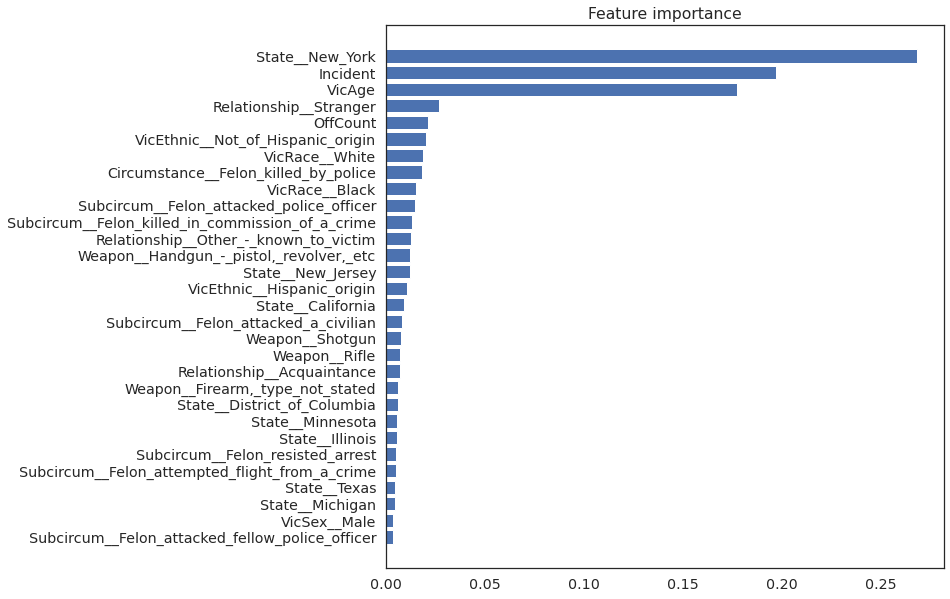

In [ ]:
I = np.argsort(dt.feature_importances_) # Sort smallest to large
plt.figure(figsize = (10,10))
plt.title("Feature importance")
plt.barh(new_df.columns[I[len(I)-30:len(I)]], dt.feature_importances_[I[len(I)-30:len(I)]])
plt.show()

In [ ]:
errs = []
for _ in range(500):
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = 0.2)
    dt = DecisionTreeClassifier()
    dt.fit(X_tr, y_tr)
    y_pr = dt.predict(X_te)
    err = np.mean(y_pr != y_te)
    errs.append(err)

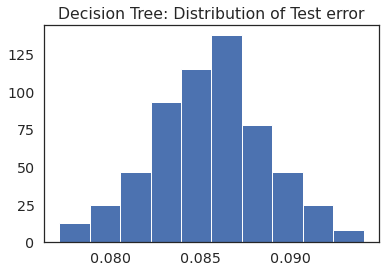

In [ ]:
plt.hist(errs, density=True)
plt.title("Decision Tree: Distribution of Test error")
plt.show()

From a result of Decision Tree model, testing errors are resonably lower ranged from 0.075 to 0.095, less than 10%, which indicates **Tree Classifer** method is a better use for this type of prediction compared to Gaussian Naive Bayes Model.

Next, we built **Random Forest Classifer** Model to see any imporvement from basic Decision Tree Classifer method.

testing error = 0.057927 training error = 0.005079


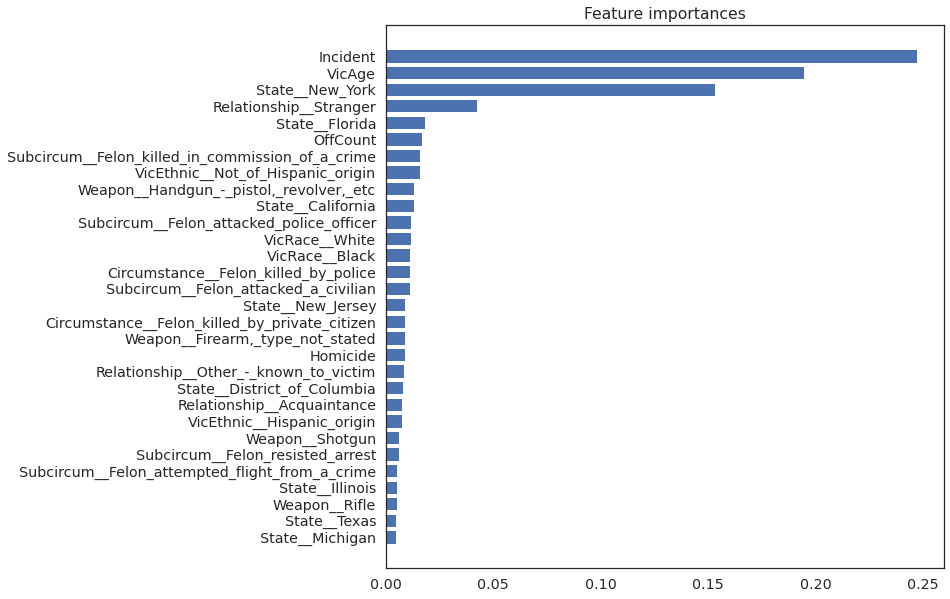

In [ ]:
# Build Random Forest Model
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1)

np.random.seed(22)
rf.fit(X_tr, y_tr)

y_pr_tr = rf.predict(X_tr)
tr_err = np.mean(y_pr_tr != y_tr)

y_pr = rf.predict(X_te)
test_err = np.mean(y_pr != y_te)
print(f"testing error = {test_err:.6f}", f"training error = {tr_err:.6f}")

I = np.argsort(rf.feature_importances_)
plt.figure(figsize=(10,10))
plt.title("Feature importances")
plt.barh(new_df.columns[I[len(I)-30:len(I)]], rf.feature_importances_[I[len(I)-30:len(I)]])
plt.show()

From an above result, an improvement of model accuracy was confirmed: testing error of Random Forest Model is 5.7% whcih is smaller than the onf of Decisino Tree (7.5 ~ 9.5%). 
Based on the plot of the Features importance, Incident (case number within the month in whcih homicide occured), certain Victim's profile, Geographical info i.e. state and type of killing methods (weapon, circumstance etc.) are nominated as top 30 key features. 


In terms of Geographic locations, as you can see see from below Map, high unsolved rate is reported from certain state such as New York, New Jersey, Illinoi, California, Michigan, and Florida where nominated as top 30 important features of our Random Foreste Model.

This indicates that geographic information could be useful to predict the difficulty of solving crimes with other combination of attributes.

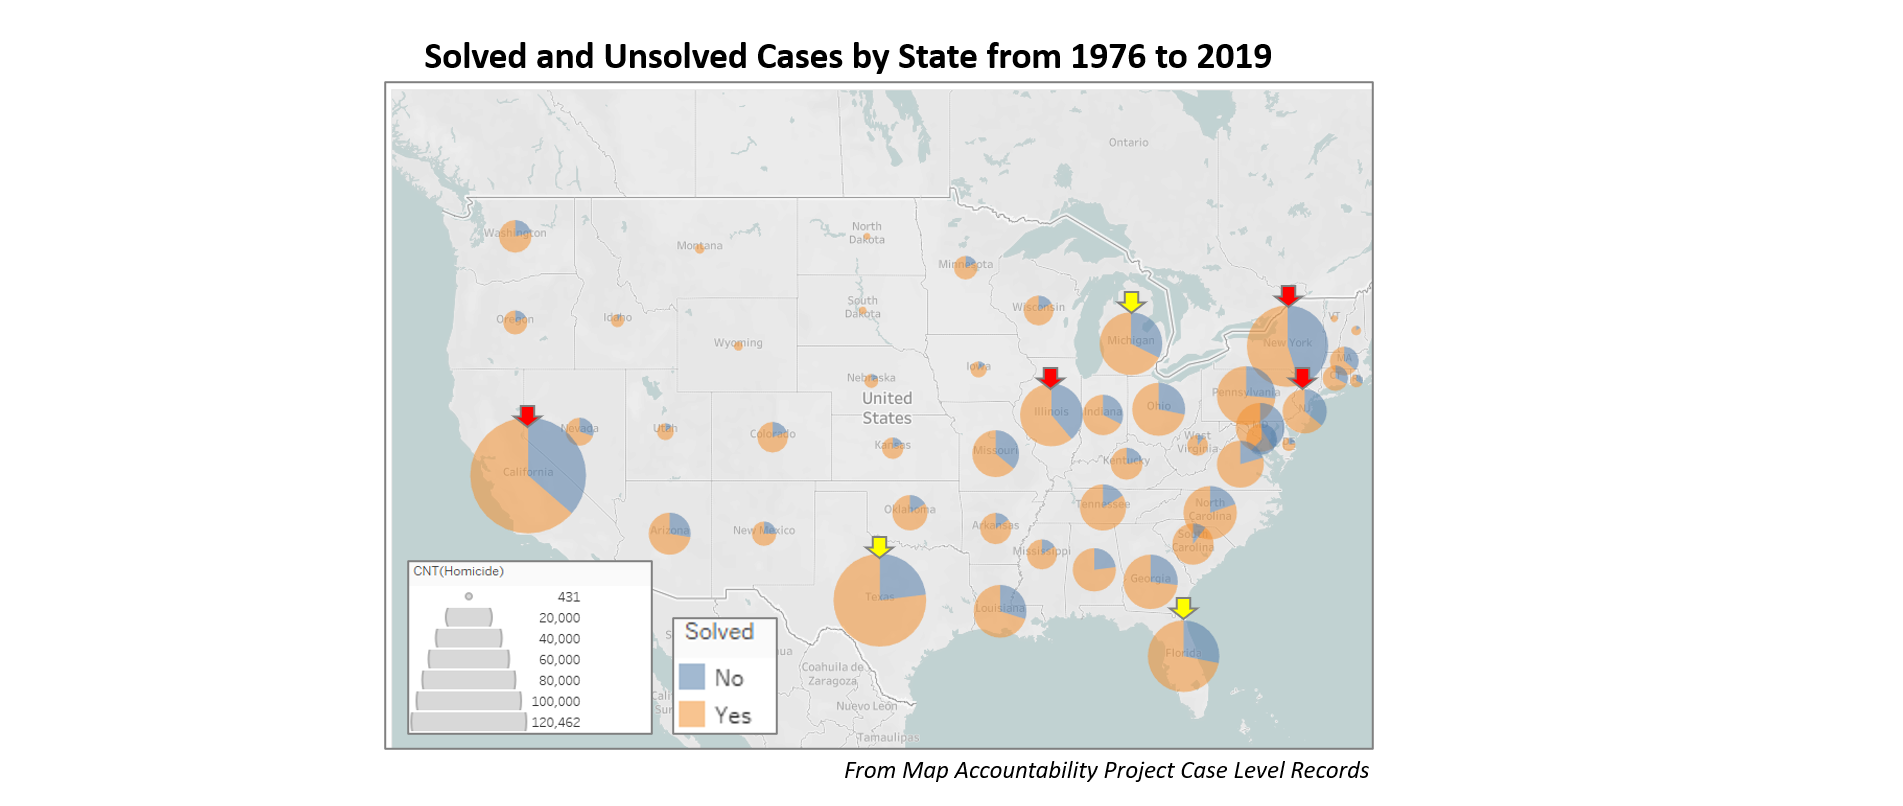
*Fig. Solved and Unsolved Cases by state from 1976 to 2019*

Below figure shows the distribution of Victim Profile, Weapon Type, Relationships, and Circumstance colored by Solved or Unsolved cases.
The categories highlighted with red boxes, are the top 30 features variables.

No strong trends are confirmed from those distributions but the rate of solved or unsolved cases in certain categories could be distinguished from others. For example, almost cases whcih Relationships are labeled as "stranger", "Acqualntance" and "others - known to civtim" are classified as "solved". 

On the other hand, about 35% of cases which weapon type are "Handgun - pistol, revolver, etc" are unsolved. Compared to the cases whcih weapon type are "Rifle" or "Shotgun", above weapon type cases would be more difficult to solve.

Those infomation provide potential indicators of solved or unsolved classification but it is still inconclusive and limited from the data mining - checking distribution one by one. 

However, it could turn to be very useful information when we combine all potential indicators together to implement machine learning to predict solved / unsolved cases. 


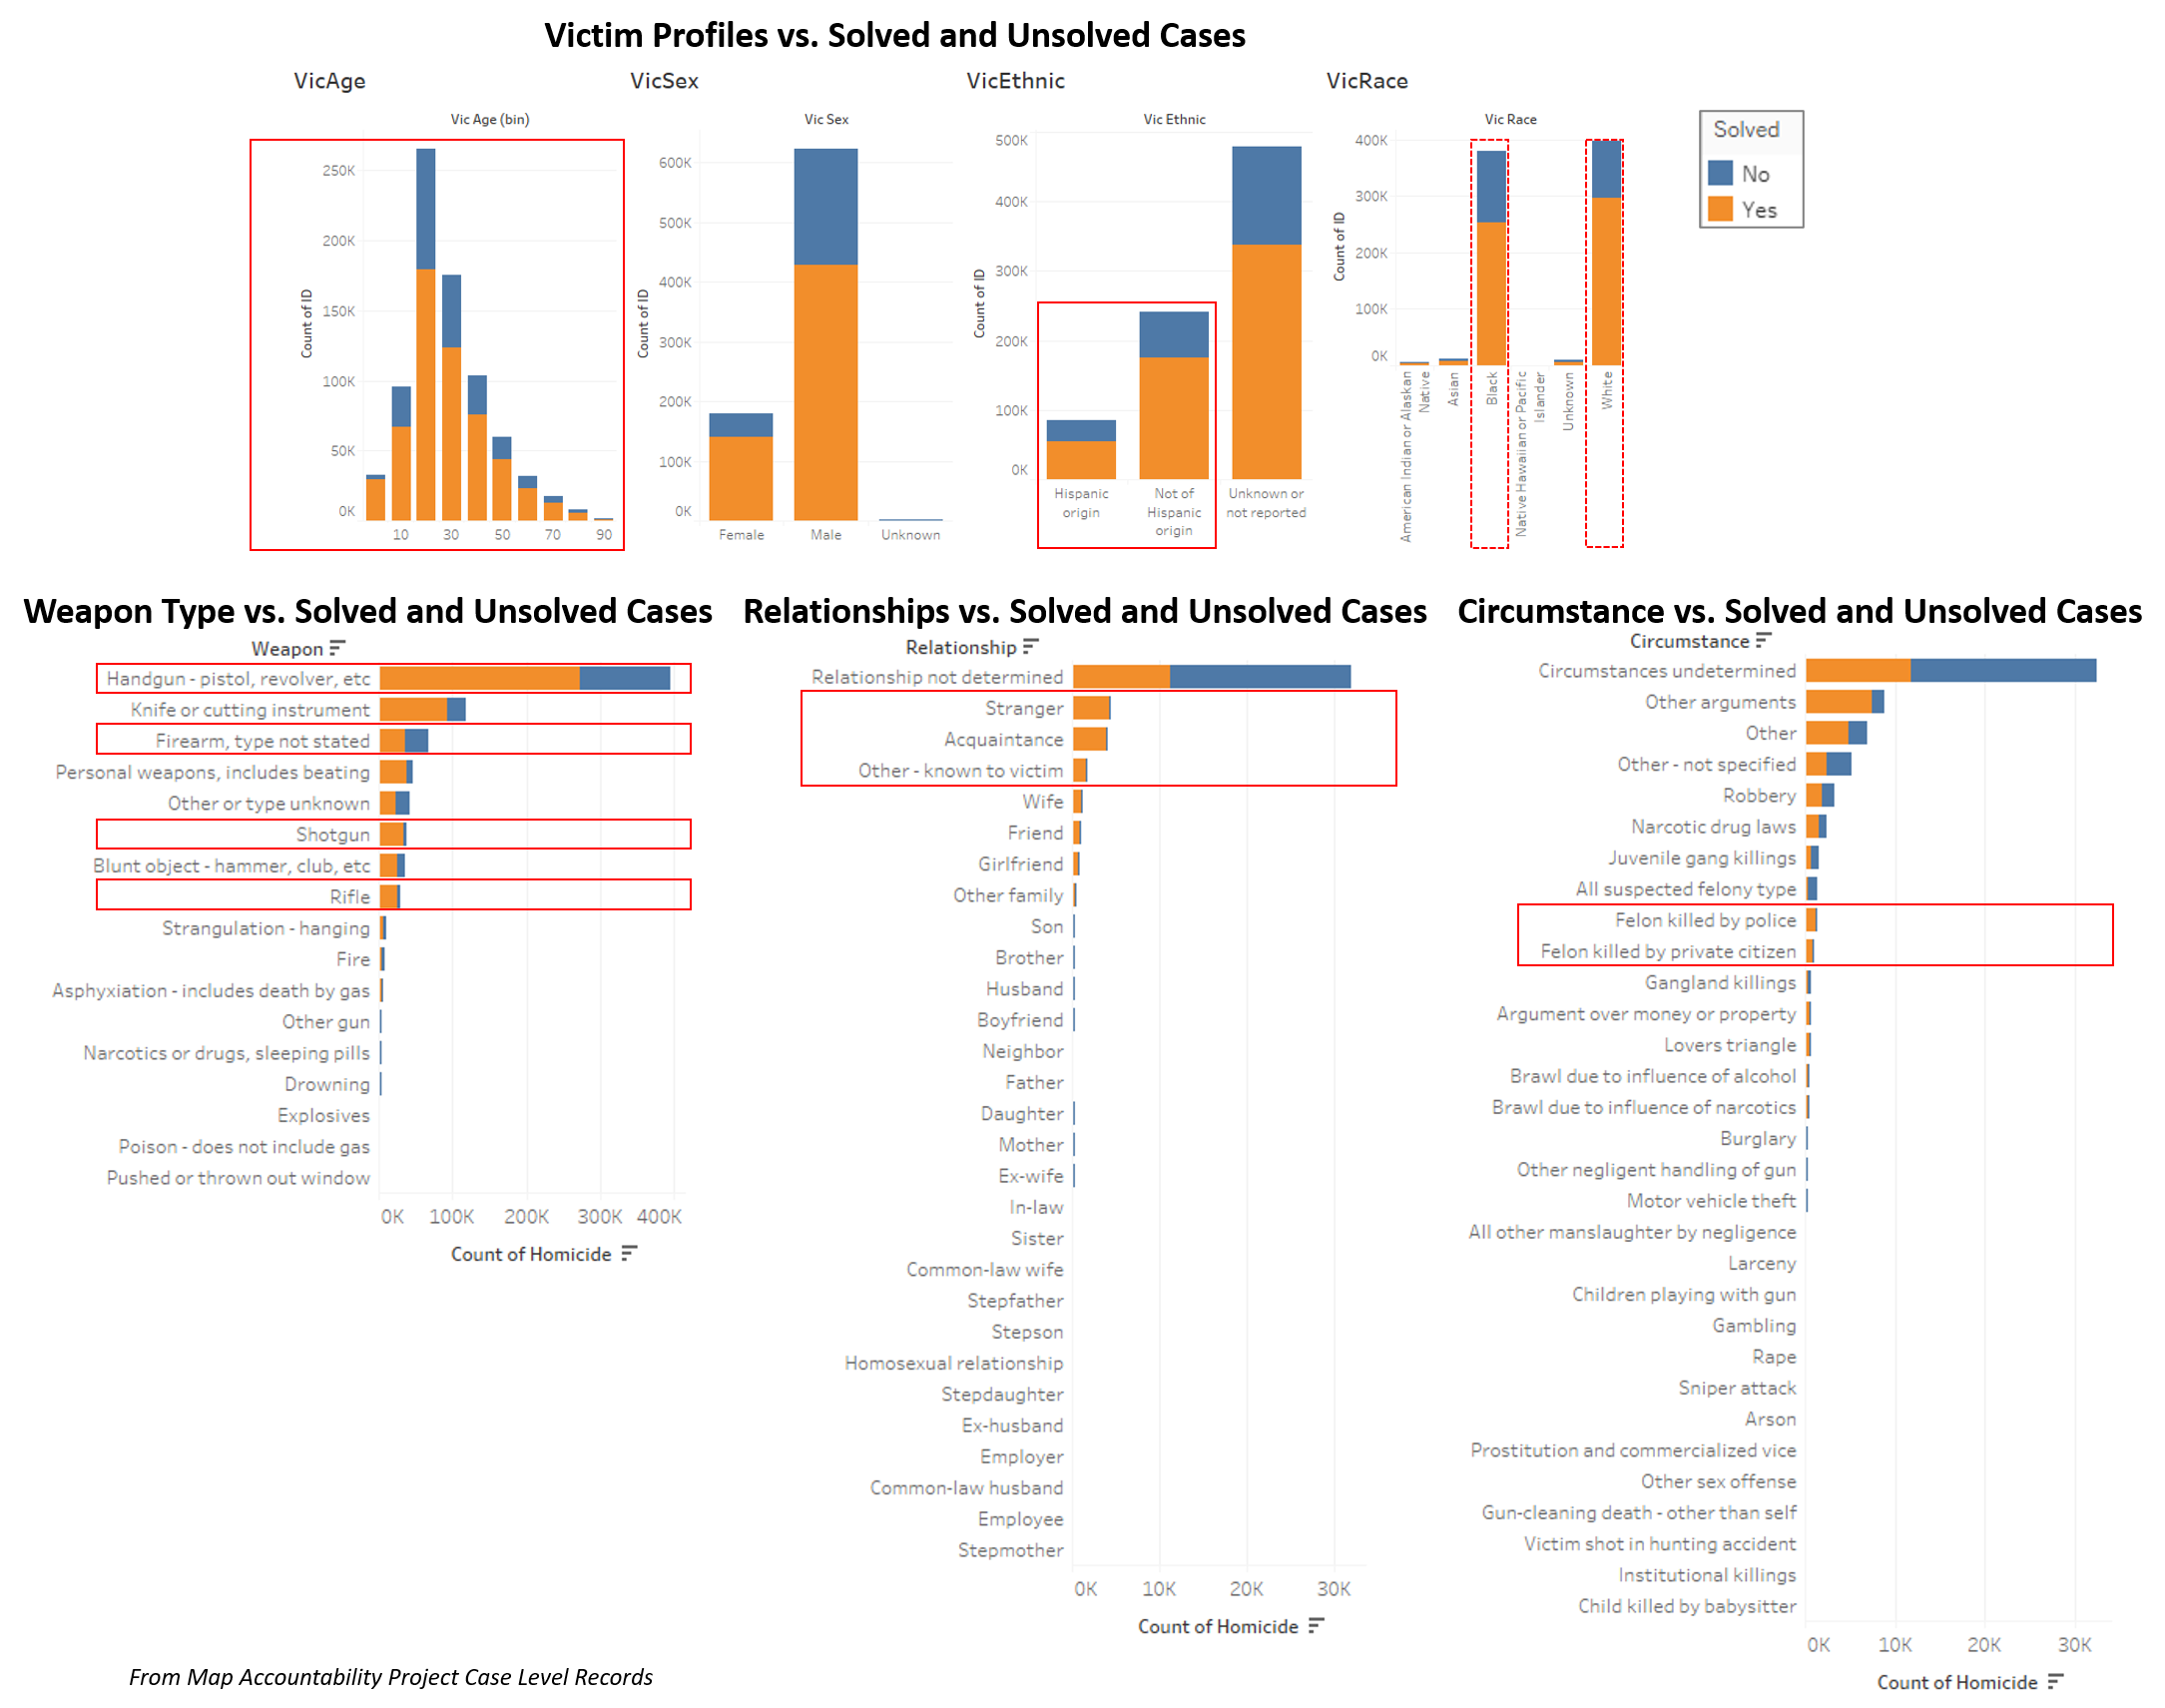
*Fig. Solved and Unsolved Cases vs. Victim Profiles, Weapon Type, Relationships, and Circumstance*

## Hyperparameter Tuning with Grid Search
To find a room of improvement of training and testing accuracy of the random forest classifer model, Hyperparameter tunning is useful to keep track of which combination of parameters perform best. 
We used GridSearchCV to find best combination of parameters for Random Forest Classifer.
#### RandomForest Parameters
- n_estimators: number of tree
- Max features: Random forest models randomly resample features prior to determining the best split. Max_features determines the number of features to resample. Larger max_feature values can result in improved model performance because trees have a larger selection of features from which choose the best split, but can also cause trees to be less diverse and induce overfitting. The common theme here is one needs to identify an optimal value that balances overfitting and under-fitting. Common choices include:
    ‘auto’: places no restrictions on the number of features,
    ‘sqrt’: square root of the total number of features,
    ‘log2’: base two logarithm of the total number of features.
- Max_depth:Each tree in the random forest model makes multiple splits to isolate homogeneous groups of outcomes. Larger numbers of splits allowed in each tree enables the trees to explain more variation in the data, however, trees with many splits may overfit the data. A range of depth values should be evaluated, including “None” where trees are split until all the leaves are pure.


In [ ]:
from sklearn.model_selection import GridSearchCV

gridsearch_forest = RandomForestClassifier()

params = {
    "n_estimators": [100, 300, 500],
    "max_depth": [5,8,15],
    "min_samples_leaf" : [1, 2, 4],
    "max_features": ['auto', 'log2', 'sqrt']
}

rf_grid = GridSearchCV(gridsearch_forest, param_grid=params, cv=5 )
rf_grid.fit(X_tr,y_tr)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
print(rf_grid.best_params_)

{'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 300}


From above, {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 300} is the best combination of Random Forest Classifer. Use these parameters and check testing and training error.

testing error = 0.052214 training error = 0.051307


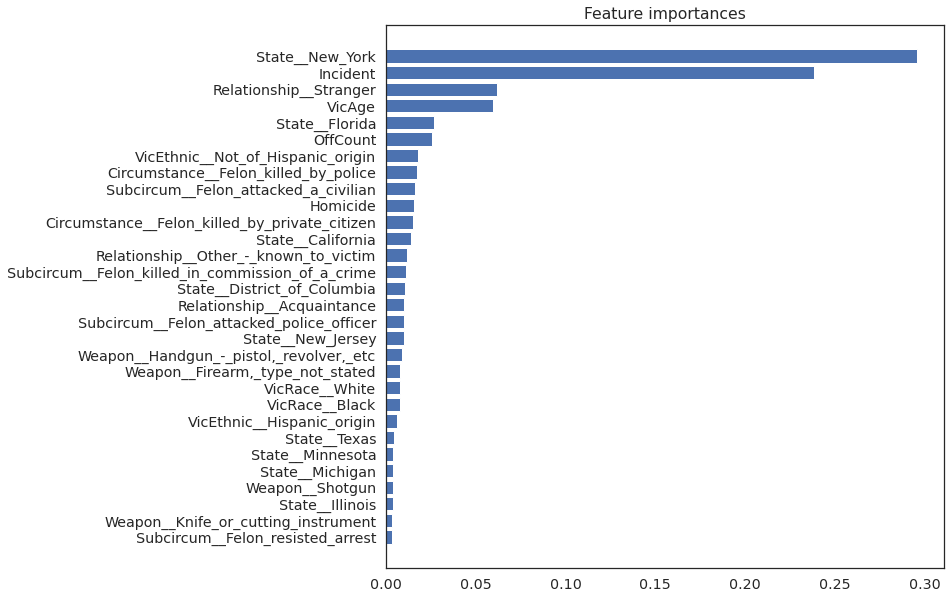

In [ ]:
rf = RandomForestClassifier(n_estimators=300, min_samples_leaf = 1, max_depth = 15, max_features = 'sqrt', oob_score=True, n_jobs=-1)

rf.fit(X_tr, y_tr)

y_pr_tr = rf.predict(X_tr)
tr_err = np.mean(y_pr_tr != y_tr)

y_pr = rf.predict(X_te)
test_err = np.mean(y_pr != y_te)
print(f"testing error = {test_err:.6f}", f"training error = {tr_err:.6f}")

I = np.argsort(rf.feature_importances_)
plt.figure(figsize=(10,10))
plt.title("Feature importances")
plt.barh(new_df.columns[I[len(I)-30:len(I)]], rf.feature_importances_[I[len(I)-30:len(I)]])
plt.show()

You can see a slight decrease of testing error from 5.8% to 5.2% with optimized model parameters.
One thing we noticed is that we got equivalent errors between test and training dataset from this model, which means the model is not overfitted. Previous Random Forest Classifer Model gaves us a very small training error ~ 0.5% even testing error is 5.7% which we clearly overfit the model.

Therefore we could support our **Random Forest Model** results as a candidate of best fitted modesl to help to distinguish the solved from unsolved caese of homicides crime records in US. 